# Skin Cancer Prediction from Images

## Setup and Exploratory Data Analysis

In [2]:
import tensorflow as tf
from tensorflow.config import list_physical_devices
from tensorflow.config.experimental import get_device_details
from tensorflow import keras
from tensorflow.keras.utils import set_random_seed, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAvgPool2D, GlobalMaxPool2D, Rescaling, RandomTranslation, RandomFlip, RandomRotation, RandomZoom, BatchNormalization, Resizing
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception, preprocess_input 

from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from tqdm import tqdm

import kagglehub

/Users/adrianbrudnicki/code/python/skin-cancer-detection/.venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set_theme(style="whitegrid")
sns.color_palette("Set2")

RANDOM_SEED = 0
set_random_seed(RANDOM_SEED)

BATCH_SIZE = 64 
NUM_EPOCHS = 40 

devices = list_physical_devices()
print(f"Devices: {devices}")

gpus = list_physical_devices("GPU")
if gpus:
  details = get_device_details(gpus[0])
  print(f"GPU details: {details}")

Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: {'device_name': 'METAL'}


Let's download the data from kaggle

In [4]:
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset:", path)

Path to dataset: /Users/adrianbrudnicki/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


We'll list the files to confirm we can see what is expected.  There should be a metadata csv file, 4 csv files corresponding to b/w and color, and 8x8 and 28x28 sizes, as well as two folders with full size images in JPG format.  

In [5]:
for filename in os.listdir(path):
    print(filename)

test_images
hmnist_28_28_L.csv
.DS_Store
hmnist_28_28_RGB.csv
HAM10000_images_part_1
HAM10000_images_merged
hmnist_8_8_RGB.csv
train_images
hmnist_8_8_L.csv
HAM10000_images_part_2
HAM10000_metadata.csv


And now let's take a peak inside the metadata and the 28x28 rgb csv files.

In [6]:
meta_df = pd.read_csv(os.path.join(path, "HAM10000_metadata.csv"))
meta_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [7]:
mnist_28RGB_df = pd.read_csv(os.path.join(path, "hmnist_28_28_RGB.csv"))
mnist_28RGB_df.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

I've run this model with the 28x28 images and wasn't able to get very good results, so we will use the full resolution images.  For this application, the extra information from the higher resolution really matters.  Let's create a few helper dictionaries that will be useful later on, and then load the image files into tf.Datasets.  

In [8]:
labels_dict = {0: "akiec",1:"bcc",2 :"bkl" , 3: "df",4: "nv",5: "vasc",6: "mel"}
labels_dict_r = {v: k for k, v in labels_dict.items()}
labels_list = list(labels_dict.values())
label_descriptions= {
    'nv': 'Melanocytic nevus',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesion',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratosis',
    'vasc': 'Vascular lesion',
    'df': 'Dermatofibroma'
}

In [9]:
# # Merge the two image directories into one and remove duplicates
img_dir1 = os.path.join(path, "HAM10000_images_part_1") 
img_dir2 = os.path.join(path, "HAM10000_images_part_2")
merged_img_dir = os.path.join(path, "HAM10000_images_merged")
if not os.path.exists(merged_img_dir):
    os.makedirs(merged_img_dir) 
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".jpg"):
            old_path = os.path.join(root, file)
            new_path = os.path.join(merged_img_dir, file)
            if not os.path.exists(new_path):
                shutil.copy(old_path, new_path)


In [10]:
image_files = sorted([f for f in os.listdir(merged_img_dir) if f.endswith('.jpg')])
num_images = len(image_files)
X = np.empty((num_images, 224, 224, 3), dtype=np.uint8)
y = np.empty((num_images), dtype=np.uint8)

for i, fname in enumerate(tqdm(image_files, desc="Loading and resizing images")):
    img = load_img(os.path.join(merged_img_dir, fname), target_size=(224, 224))
    X[i] = np.array(img)
    y[i] = labels_dict_r[meta_df[meta_df.image_id == fname[:-4]].dx.values[0]]
print(f"X shape: {X.shape}, y shape: {y.shape}")

Loading and resizing images: 100%|██████████| 10015/10015 [00:47<00:00, 210.12it/s]

X shape: (10015, 224, 224, 3), y shape: (10015,)


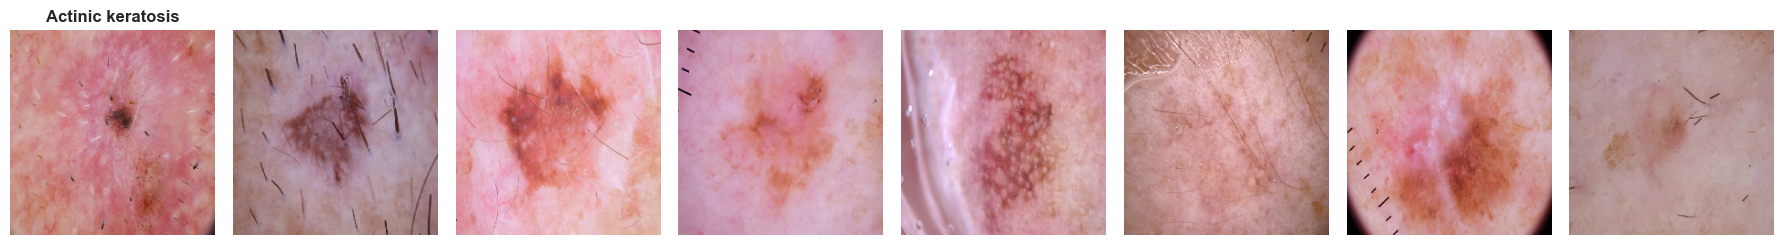

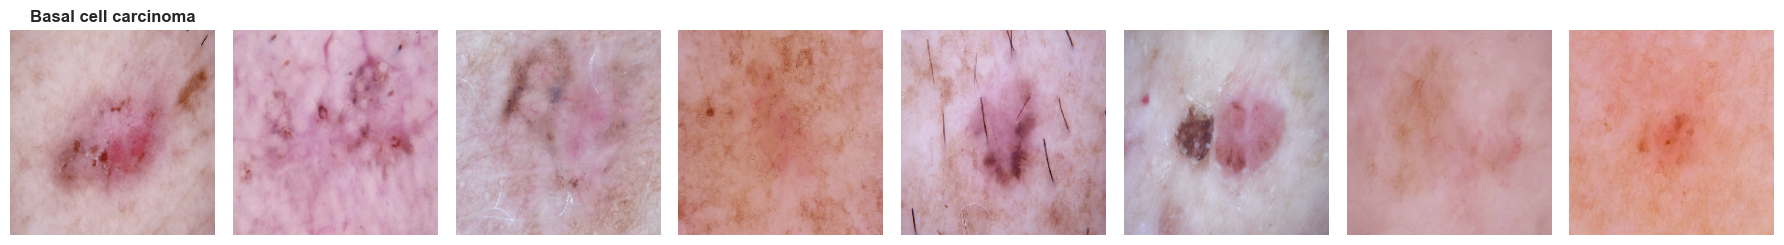

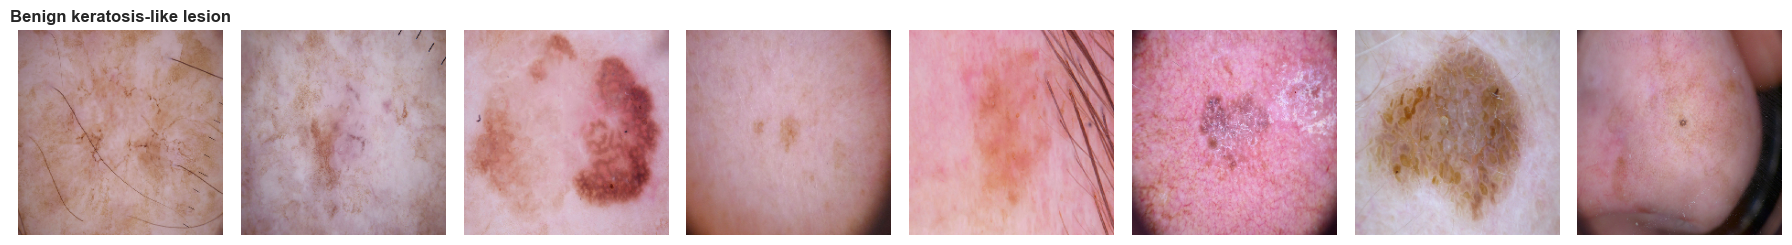

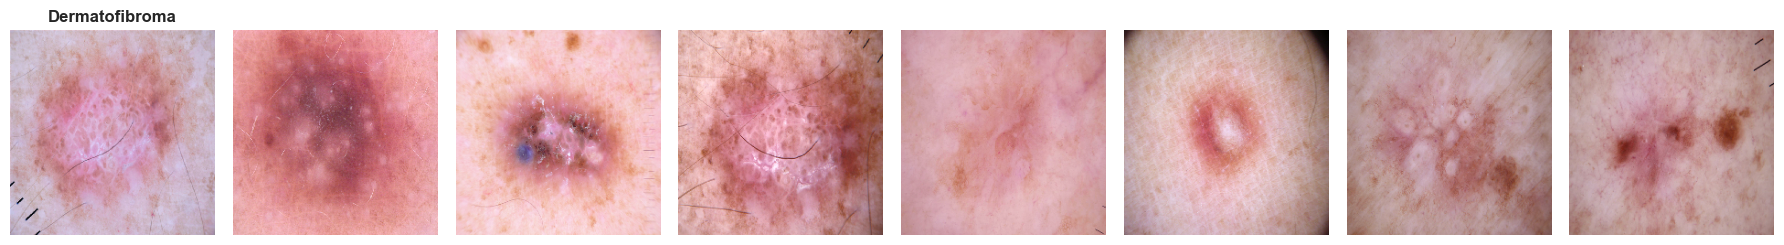

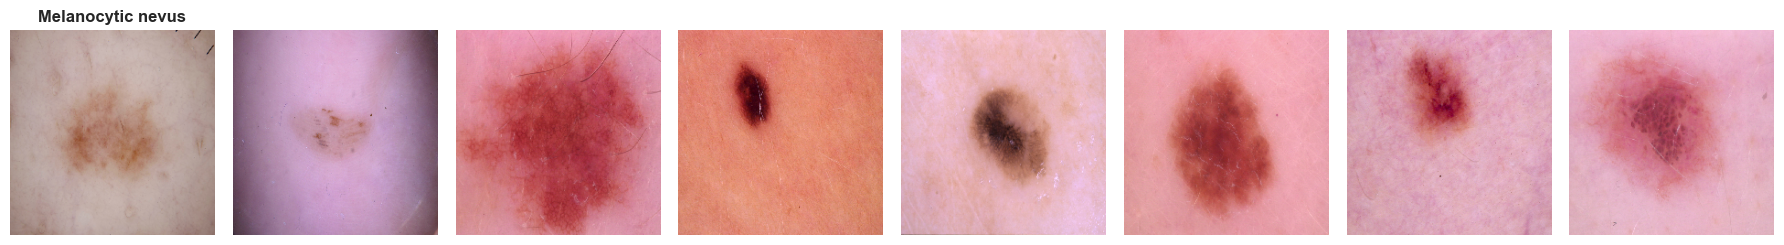

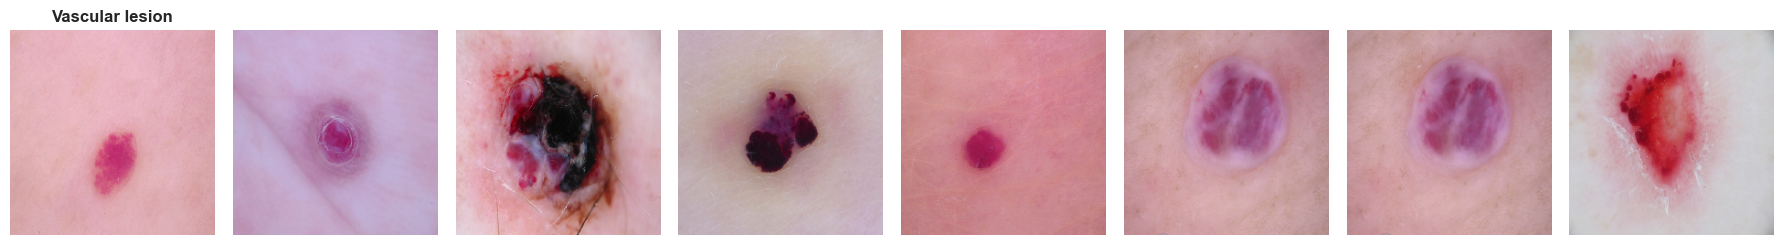

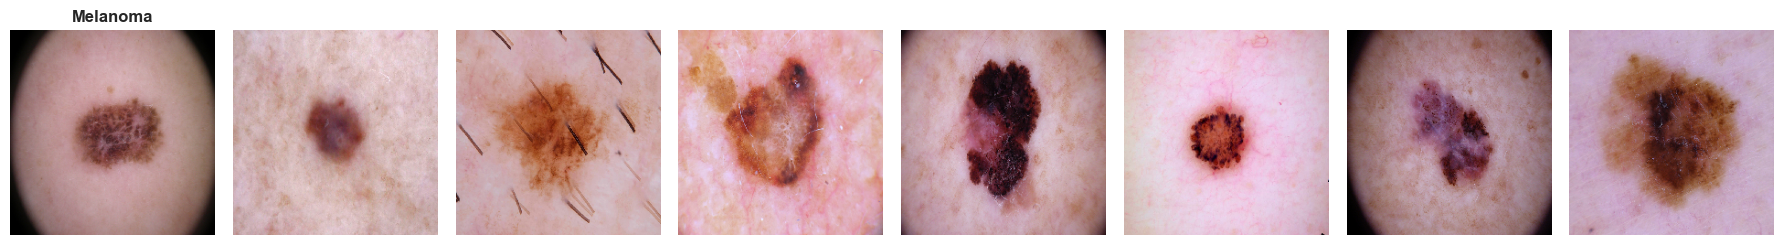

In [11]:
for l in labels_dict.keys():
    plt.figure(figsize=(18, 4))
    y_idx = np.where(y==l)[0]
    for i in range(8):
        if i == 1:
            ax.set_title(label_descriptions[labels_dict[l]], fontweight="bold", fontsize=12)
        ax = plt.subplot(1, 8, i+1)
        img = X[np.random.choice(y_idx)]
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Skin Cancer Prediction from Images

## Setup and Exploratory Data Analysis

How does the distribution of labels look like?  We'll graph these with respect to sex.  

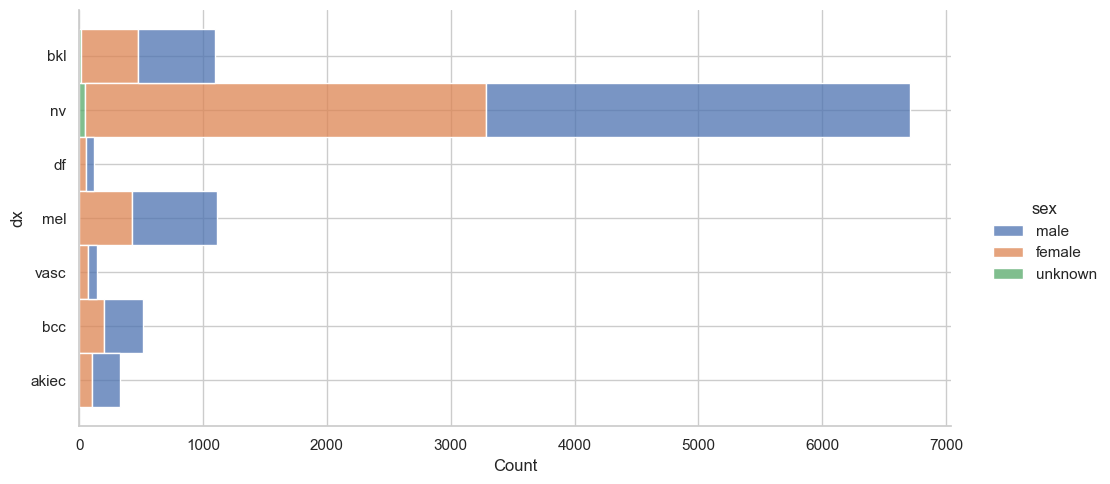

In [11]:
g = sns.displot(data=meta_df, y="dx", hue="sex", kind="hist", multiple="stack", height=5, aspect=2)
plt.show()

What about localization?

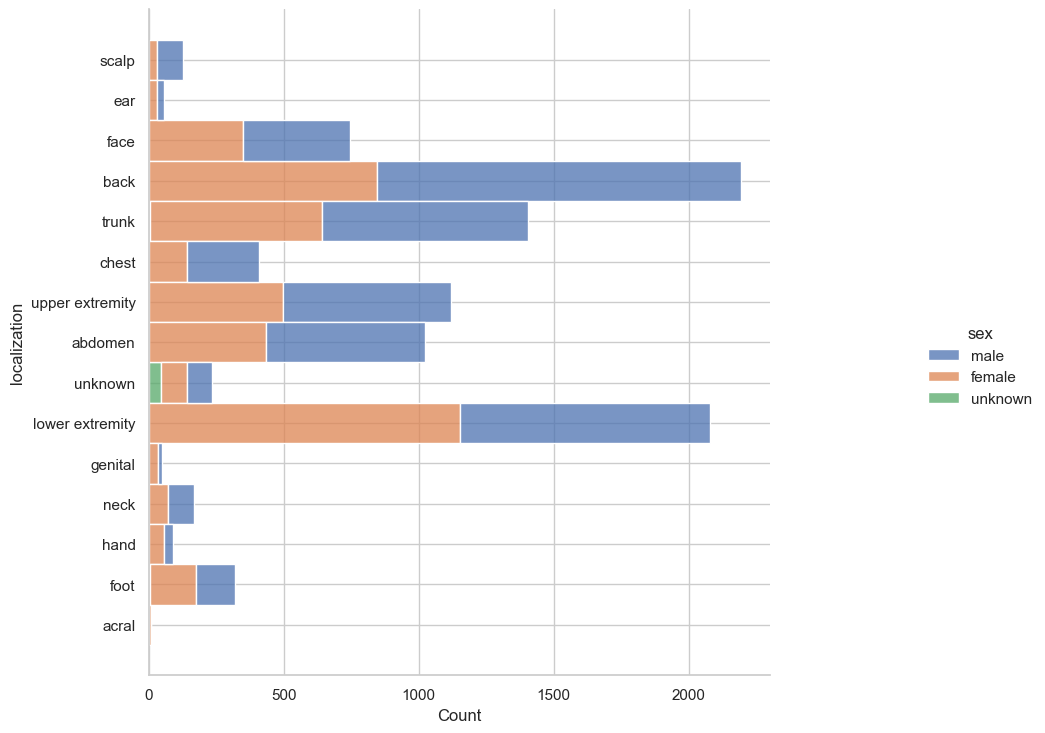

In [12]:
g = sns.displot(data=meta_df, y="localization", hue="sex", multiple="stack")
g.figure.set_size_inches(12, 8)
plt.show()

And finally, age.  

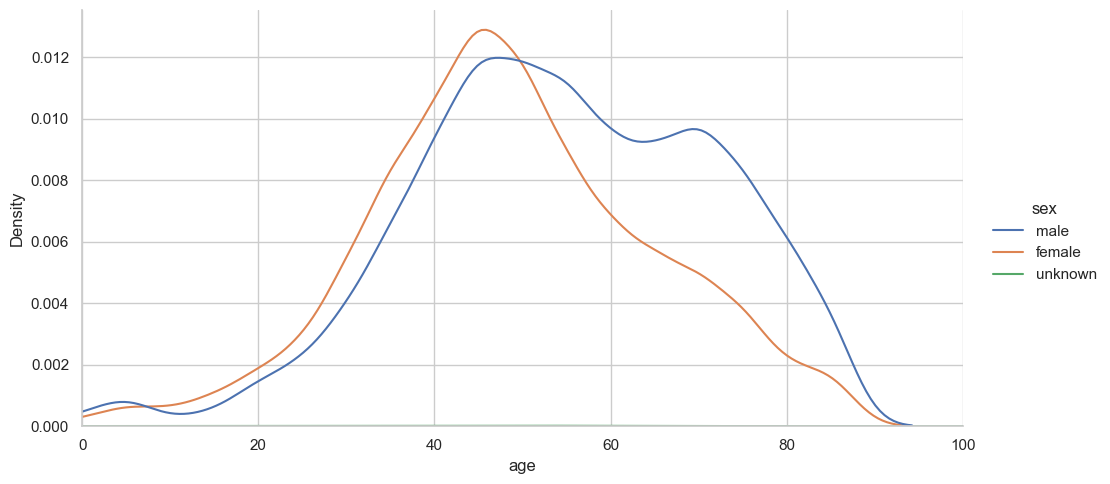

In [13]:
g = sns.displot(data=meta_df, x="age", kind="kde", hue="sex", height=5, aspect=2)
plt.xlim(0, 100)
plt.show()

Interesting, most of the samples are of benign moles, which is unsurprising.  But this will leave us with an imbalanced data set.  The distribution by sex is relatively even, except when considering age.  The shape of the kde curve looks shifted left for women, and men have a large bump around 70 (along with a generally higher representation in old age).

## Data Preprocessing

Let's create a data augmentation layer. I think the most effective method will be to simply allow full rotation of the sample images.  This should have a reasonably strong regulariztion effect, and will be helpful when oversampling the minority classes later.   

In [14]:
data_augmentation = Sequential([
      RandomRotation(factor=0.2),
      RandomTranslation(height_factor=0.1, width_factor=0.1),
      RandomZoom(height_factor=0.1, width_factor=0.1),
      RandomFlip("horizontal_and_vertical"),
   ]) 

2025-08-13 10:17:08.858823: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-08-13 10:17:08.858854: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-08-13 10:17:08.858878: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1755101828.858937 10825215 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1755101828.858961 10825215 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


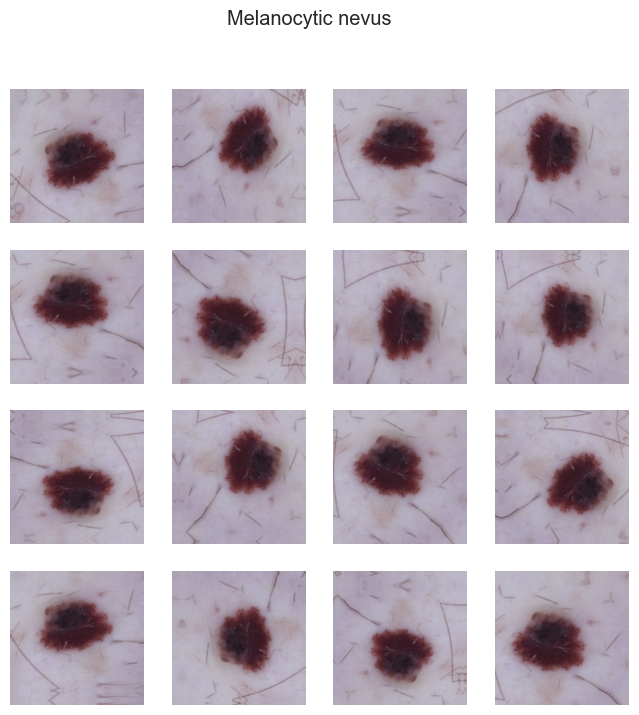

In [15]:
fig = plt.figure(figsize=(8, 8))
rand_idx = np.random.randint(len(X))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = data_augmentation(np.expand_dims(X[rand_idx], axis=0))
    ax.imshow(np.squeeze(img/255))
    ax.axis("off")
plt.suptitle(label_descriptions[labels_dict[y[rand_idx]]])
plt.show()

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=RANDOM_SEED, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp)

In [17]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((6009, 224, 224, 3),
 (2003, 224, 224, 3),
 (2003, 224, 224, 3),
 (6009,),
 (2003,),
 (2003,))

In [18]:
class_freq = meta_df.dx.value_counts()
class_probs = class_freq / len(meta_df) 
class_probs.index = class_probs.index.map(labels_dict_r)
class_probs = class_probs.sort_index()
init_bias = np.array(np.log(class_probs))

In [20]:
reshaped_X_train = X_train.reshape(X_train.shape[0], -1)
oversampler = RandomOverSampler(sampling_strategy="auto", random_state=RANDOM_SEED)
X_train_over, y_train_over = oversampler.fit_resample(reshaped_X_train, y_train)
X_train_over = X_train_over.reshape(-1, 224, 224, 3)
X_train_over.shape, y_train_over.shape

((28161, 224, 224, 3), (28161,))

## Model Selection and Evaluation

Let's set up our model.  

In [ ]:
base_model = Xception(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [26]:
# base_model.summary()

In [27]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = GlobalMaxPool2D()(x)  
x = Dense(units=512, activation="relu")(x)
x = Dropout(.5)(x)
outputs = Dense(units=7, activation="softmax", bias_initializer=init_bias)(x)
model = keras.Model(inputs, outputs)

In [28]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,914,159 (83.60 MB)

 Trainable params: 21,859,631 (83.39 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
optimizer = Adam(learning_rate=1e-4)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, min_lr=1e-6, cooldown=2, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="auto", verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath="best_model.keras", monitor="val_accuracy", mode="auto", save_best_only=True, verbose=1)
cb = [reduce_lr, checkpoint]
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]) 


In [32]:
with tf.device("GPU: 0"):
    history = model.fit(X_train_over, y_train_over, validation_data=(X_valid, y_valid), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=cb)

Epoch 1/40


2025-08-13 10:18:17.319067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5176 - loss: 1.4644
Epoch 1: val_accuracy improved from -inf to 0.66301, saving model to best_model.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 1142s 3s/step - accuracy: 0.5180 - loss: 1.4632 - val_accuracy: 0.6630 - val_loss: 1.1023 - learning_rate: 1.0000e-04
Epoch 2/40
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8620 - loss: 0.4175
Epoch 2: val_accuracy improved from 0.66301 to 0.74338, saving model to best_model.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 1158s 3s/step - accuracy: 0.8621 - loss: 0.4174 - val_accuracy: 0.7434 - val_loss: 0.9379 - learning_rate: 1.0000e-04
Epoch 3/40
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9056 - loss: 0.2755
Epoch 3: val_accuracy improved from 0.74338 to 0.75537, saving model to best_model.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 3079s 7s/step - accuracy: 0.9056 - loss: 0.2754 - val_accuracy: 0.7554 - val_loss: 1.0041 - learning_rate: 1.0000e-04
Epoch 4/40
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step 

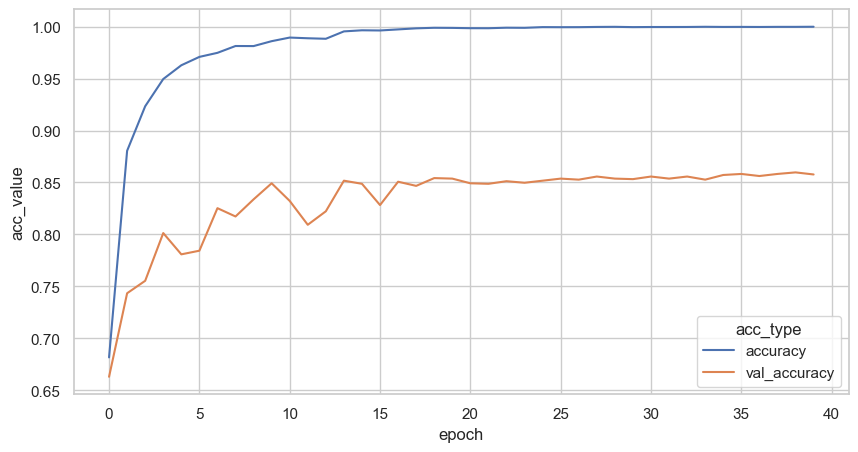

In [33]:
hist = pd.DataFrame(history.history).reset_index()
acc_pd = pd.melt(hist, id_vars=["index"], value_vars=["accuracy", "val_accuracy"]).rename(columns={"variable": "acc_type", "value": "acc_value", "index": "epoch"})
ax = sns.lineplot(data=acc_pd, x="epoch", y="acc_value", hue="acc_type")
ax.figure.set_size_inches(10, 5)
plt.show(ax)

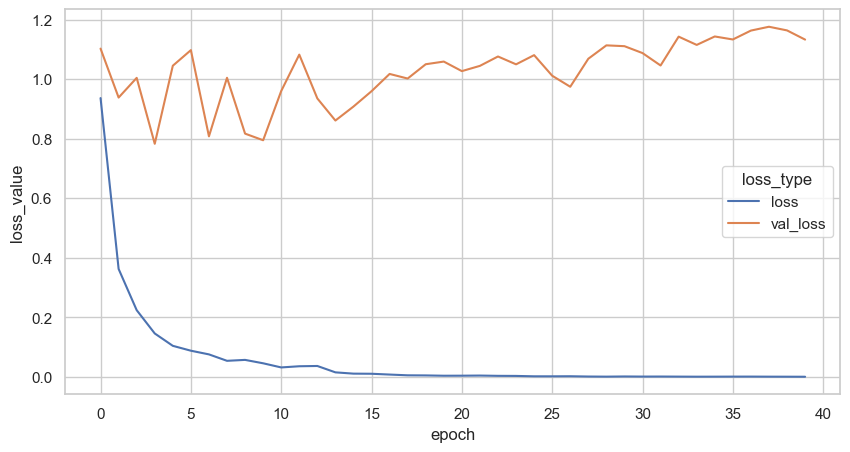

In [34]:
loss_pd = pd.melt(hist, id_vars=["index"], value_vars=["loss", "val_loss"]).rename(columns={"variable": "loss_type", "value": "loss_value", "index": "epoch"})
ax = sns.lineplot(data=loss_pd, x="epoch", y="loss_value", hue="loss_type")
ax.figure.set_size_inches(10, 5)
plt.show(ax)

In [35]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

63/63 - 17s - 272ms/step - accuracy: 0.8542 - loss: 1.1805


In [36]:
y_pred = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 257ms/step


In [37]:
print(classification_report(y_test, np.argmax(y_pred, axis=1), target_names=labels_list))

              precision    recall  f1-score   support

       akiec       0.71      0.53      0.61        66
         bcc       0.87      0.72      0.79       103
         bkl       0.70      0.78      0.74       220
          df       0.71      0.65      0.68        23
          nv       0.93      0.92      0.93      1341
        vasc       0.96      0.93      0.95        28
         mel       0.61      0.69      0.65       222

    accuracy                           0.85      2003
   macro avg       0.79      0.75      0.76      2003
weighted avg       0.86      0.85      0.86      2003



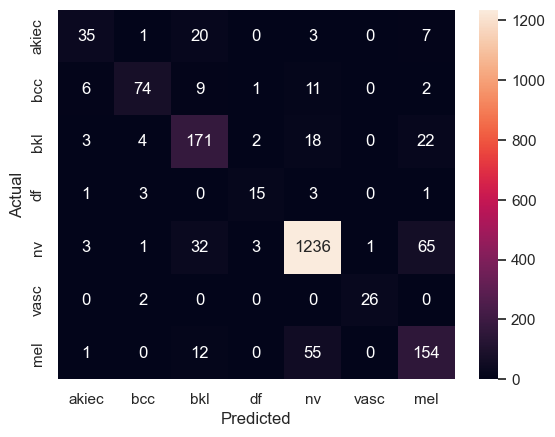

In [38]:
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
ax = sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_list, yticklabels=labels_list)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show(ax)
